<img src="architecture_overview.png" width="800"/>




We'll use this notebook to prepare the dataset. We want to use text and vision encodings from pretrained models like CLIP, and then use the Flicker dataset to train the decoder's understanding of image and captions. 

In [3]:
from datasets import load_dataset, Image


dataset = load_dataset("nlphuji/flickr30k",split="test", streaming=True, trust_remote_code=True)

# Get the first example
one_sample = next(iter(dataset.take(1)))
print(one_sample)


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x122D582D0>, 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.'], 'sentids': ['0', '1', '2', '3', '4'], 'split': 'train', 'img_id': '0', 'filename': '1000092795.jpg'}


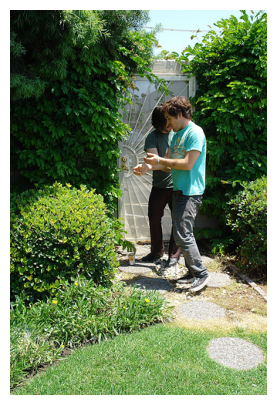

1. Two young guys with shaggy hair look at their hands while hanging out in the yard.
2. Two young, White males are outside near many bushes.
3. Two men in green shirts are standing in a yard.
4. A man in a blue shirt standing in a garden.
5. Two friends enjoy time spent together.


In [4]:
import matplotlib.pyplot as plt

# set fig size
plt.figure(figsize=(10, 5))

# plot image
plt.imshow(one_sample["image"])
plt.axis("off")
plt.show()

for i, caption in enumerate(one_sample["caption"]):
    print(f"{i+1}. {caption}")



### STEP 1: IMPORT PRETRAINED CLIP, TAKE TEXT EMBEDDINGS, AND USE PRETRAINED CLIP VISION ENCODER AS YOUR ENCODER  

CLIP’s vision encoder is a ViT (Vision Transformer) model. Here's how it works:

* It divides an image into patches (e.g., 16x16 pixels).
* It embeds each patch into a vector.
* It prepends a [CLS] token and processes the sequence of patches through transformer layers.
* It outputs:
    * One vector for each patch (and the CLS token) → total of num_patches + 1 tokens.  
    * Each token has dimensionality hidden_size (e.g., 512 or 768).

In [5]:
import transformers
import torch
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn
import numpy as np




Get the CLIP Image Encoder and freeze the weights

In [6]:
# Load the pretrained CLIP model and processor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Set to eval mode and move to GPU if available
# Set to eval mode because we don't need to compute gradients
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = clip_model.to(device)
clip_model.eval()

# Preprocess the image
inputs = clip_processor(images=one_sample["image"], return_tensors="pt", padding=True)


with torch.no_grad():

    # Freeze the image encoder
    for param in clip_model.vision_model.parameters():
        param.requires_grad = False
    
    patch_embeddings = clip_model.vision_model(**inputs).last_hidden_state # shape: [1, num_patches, hidden_dim]
    print('Patch embeddings shape:', patch_embeddings.shape)
    
    image_embedding = patch_embeddings[:, 0, :] # shape: [1, hidden_dim], uses the CLS token to get a Global Summary





Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Patch embeddings shape: torch.Size([1, 50, 768])


NEXT STEP: Use CLIP’s tokenizer and text embedding layer to embed the target captions, then train your own decoder using those embeddings.

In [7]:
# Get text embeddings
from transformers import CLIPTokenizer


def get_text_embeddings(caption):

    """
    Caption is in the dataset["caption"] column 
    """

    # Load CLIP tokenizer
    clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

    # Freeze the weights
    clip_model.text_model.embeddings.token_embedding.weight.requires_grad = False

    # Tokenize the captions
    text_inputs = clip_tokenizer(text=caption, return_tensors="pt", padding=True, truncation=True)
    print("Vocab size:",  len(text_inputs['input_ids'][0]))
    # Extract the text emebddings
    token_embeddings = clip_model.text_model.embeddings.token_embedding

    # Get token IDs
    input_ids = text_inputs["input_ids"]

    # Get the embeddings to pass to decoder
    text_embeddings = token_embeddings(input_ids)

    print('Text embeddings shape:', text_embeddings.shape)

    return text_embeddings




NEXT STEP: START DECODER

In [8]:
import torch 
import torch.nn as nn
import torch.optim as optim





In [9]:
# Create Masked Self Attention Head
class MaskedAttentionHead(nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super(MaskedAttentionHead, self).__init__()
        self.head_dim = head_dim

        # Linear projections for query, key, value
        self.weight_q = nn.Linear(embedding_dim, head_dim)
        self.weight_k = nn.Linear(embedding_dim, head_dim)
        self.weight_v = nn.Linear(embedding_dim, head_dim)

        self.linear_projection = nn.Linear(head_dim, embedding_dim)

    def forward(self, decoder_sequence):
        # embedded decoder sequence shape: [batch_size, seq_length, embedding_dim]

        # Project to head dimension
        Q = self.weight_q(decoder_sequence)
        K = self.weight_k(decoder_sequence)
        V = self.weight_v(decoder_sequence)

        # Make the mask
        seq_len = decoder_sequence.shape[1]
        mask = torch.triu(torch.ones(seq_len, seq_len, device=decoder_sequence.device), diagonal=1)
        mask = mask.masked_fill(mask==1, float('-inf'))

        # Calculate attention scores (scaled dot product)
        A = torch.einsum('bid,bjd->bij', Q, K)
        A = A / (self.head_dim ** 0.5) 

        A = A + mask
        # Apply softmax
        A = torch.softmax(A, dim=-1)

    
        #  Apply attention weights to values
        H = torch.einsum('bij,bjd->bid', A, V)
        
        # Add projection layer for output to return back to the original embedding dimension
        #output = self.linear_projection(H)

        return H

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, is_cross_attention=False):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.is_cross_attention = is_cross_attention

     
        self.heads = nn.ModuleList(
            [MaskedAttentionHead(embedding_dim, self.head_dim) for _ in range(num_heads)]
            )
        
        # The output of the CrossAttention Head and MaskedAttentionHead still needs to be projected
        # Back to the embedding dimensions of the head_dim x vocab_size
        
        self.output_projection = nn.Linear(num_heads * self.head_dim, embedding_dim)

        

    def forward(self, decoder_sequence, encoder_output=None):
        # decoder_sequence: [batch_size, seq_length, embedding_dim]
        # encoder_output: [batch_size, num_patches, embedding_dim] (only used in cross-attention)
        # mask: [batch_size, seq_length, seq_length] (only used in self-attention)

        # Process each head
        head_outputs = []
        for head in self.heads:
                # For masked self-attention, we only need decoder sequence and mask
                head_output = head(decoder_sequence)
                print("\nmasked attention head output shape: ", head_output.shape)
                
                head_outputs.append(head_output)

        # Concatenate head outputs
        concat_heads = torch.cat(head_outputs, dim=-1)
        
        # Project back to embedding dimension
        output = self.output_projection(concat_heads)
        print("Multihead attention output shape: ", output.shape)
        
        return output



In [11]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension):
        super(DecoderBlock, self).__init__()
        
        # First layer norm
        self.ln1 = nn.LayerNorm(embedding_dim)
        
        # Masked multi-head attention for decoder sequence self-attention
        self.masked_mha = MultiHeadAttention(embedding_dim, num_heads)
        
        
        # Third layer norm
        self.ln2 = nn.LayerNorm(embedding_dim)
        
        # Feed forward network
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dimension),
            nn.ReLU(),
            nn.Linear(mlp_dimension, embedding_dim)
        )

    def forward(self, decoder_sequence, encoder_output):
        # decoder_sequence: the input sequence to decode (e.g., [START, 1, 2, 3])
        # encoder_output: the encoded image from the encoder
        # mask: causal mask to prevent attending to future tokens

        # First masked self-attention block with residual connection
        # This allows decoder sequence to attend to its own past tokens
        # First masked self-attention
        residual = decoder_sequence
        decoder_sequence = self.ln1(decoder_sequence)
        decoder_sequence = self.masked_mha(decoder_sequence)
        decoder_sequence = residual + decoder_sequence

        
        # # FFN block with residual connection
        residual = decoder_sequence
        decoder_sequence = self.ln2(decoder_sequence)
        decoder_sequence = self.ffn(decoder_sequence)
        decoder_sequence = residual + decoder_sequence
        
        return decoder_sequence


class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension, num_layers, input_sequence_length, vocab_size):
        super(Decoder, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
    
        # Create positional embeddings for decoder sequence ONCE during initialization
        self.positional_embeddings = nn.Parameter(
            torch.randn(1, input_sequence_length, embedding_dim),
            requires_grad=True
        )
        
        # Create decoder blocks
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(embedding_dim, num_heads, mlp_dimension)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.final_ln = nn.LayerNorm(embedding_dim)

        # Output projection to vocabulary size
        # This converts decoder features to logits over possible next tokens
        self.output_projection = nn.Linear(embedding_dim, vocab_size)

    def forward(self, decoder_sequence, encoder_output, return_logits=True):
        # decoder_sequence: the input sequence to decode (e.g., [START, 1, 2, 3])
        # encoder_output: the encoded image from the encoder
        # return_logits: whether to return prediction logits or just decoder features
        # by default, we return logits

        embedded_decoder_sequence = self.embedding_layer(decoder_sequence)

        # Add positional embeddings to decoder sequence
        decoder_sequence = embedded_decoder_sequence + self.positional_embeddings
        
        # Pass through decoder blocks
        for block in self.decoder_blocks:
            decoder_sequence = block(decoder_sequence, encoder_output)
        
        # Apply final layer norm
        decoder_features = self.final_ln(decoder_sequence)
        
        if return_logits:
            # Convert features to logits for prediction
            # Shape: [batch_size, seq_length, vocab_size]
            logits = self.output_projection(decoder_features)
            return logits
        else:
            # Return decoder features if needed
            return decoder_features
